<ipython-input-20-6cc752ef8b1c>:9: RuntimeWarning: divide by zero encountered in scalar divide
  snr = 10 * np.log10(signal_power / noise_power)


Original SNR: inf dB
Filtered SNR: 10.74 dB


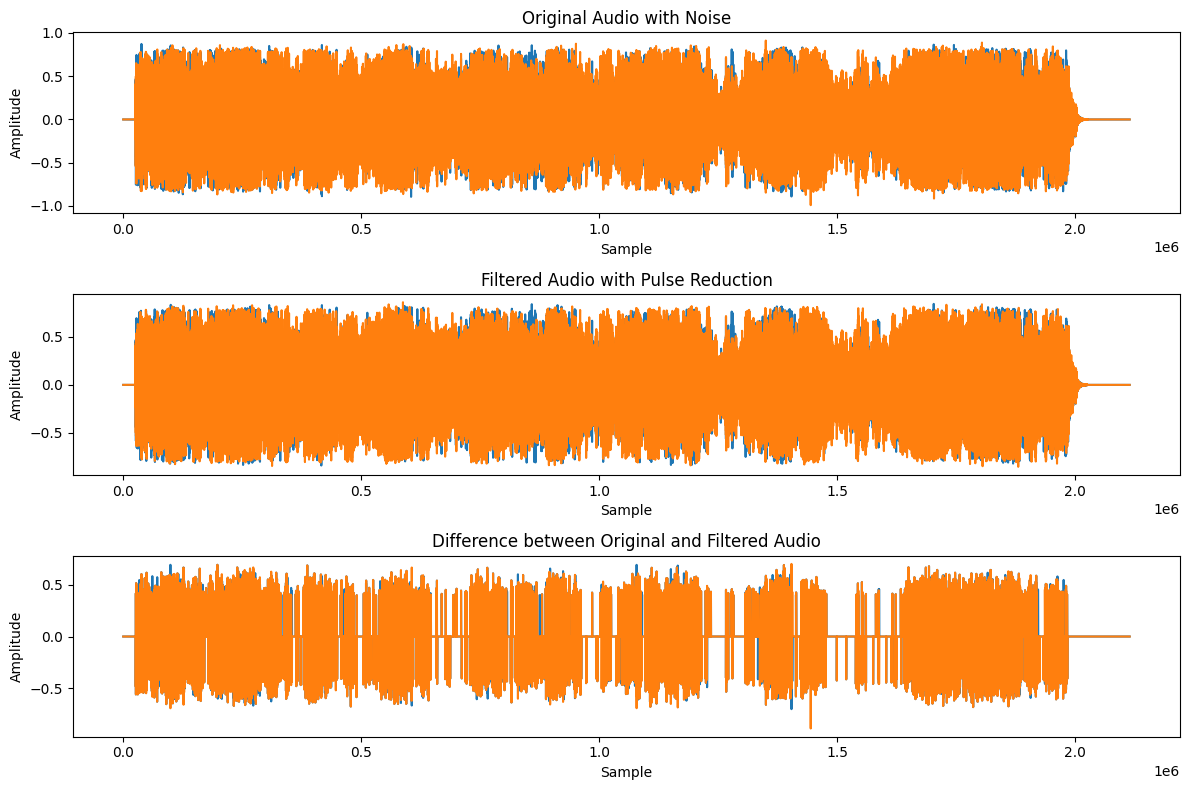

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.fft import fft, ifft

def calculate_snr(clean, noisy):
    signal_power = np.sum(clean ** 2) / len(clean)
    noise_power = np.sum((clean - noisy) ** 2) / len(clean)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

audio, sample_rate = sf.read('audio_with_noise.wav')

audio_fft = fft(audio)

cutoff_frequency = 2000
num_samples = len(audio)
frequency_indices = np.fft.fftfreq(num_samples, d=1/sample_rate)

high_amplitude_indices = np.abs(audio_fft) > np.percentile(np.abs(audio_fft), 99)
audio_fft[high_amplitude_indices] *= 0.1

filtered_audio = np.real(ifft(audio_fft))

sf.write('filtered_audio_pulse.wav', filtered_audio, sample_rate)

original_snr = calculate_snr(audio, audio)
filtered_snr = calculate_snr(audio, filtered_audio)

print(f'Original SNR: {original_snr:.2f} dB')
print(f'Filtered SNR: {filtered_snr:.2f} dB')

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(audio)
plt.title('Original Audio with Noise')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(filtered_audio)
plt.title('Filtered Audio with Pulse Reduction')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.plot(audio - filtered_audio)
plt.title('Difference between Original and Filtered Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 0.1663
Epoch 2/10
1/1 [==============================] - 7s 7s/step - loss: 0.1650
Epoch 3/10
1/1 [==============================] - 8s 8s/step - loss: 0.1640
Epoch 4/10
1/1 [==============================] - 8s 8s/step - loss: 0.1631
Epoch 5/10
1/1 [==============================] - 8s 8s/step - loss: 0.1621
Epoch 6/10
1/1 [==============================] - 8s 8s/step - loss: 0.1611
Epoch 7/10
1/1 [==============================] - 7s 7s/step - loss: 0.1600
Epoch 8/10
1/1 [==============================] - 9s 9s/step - loss: 0.1589
Epoch 9/10
1/1 [==============================] - 7s 7s/step - loss: 0.1577
Epoch 10/10
1/1 [==============================] - 3s 3s/step


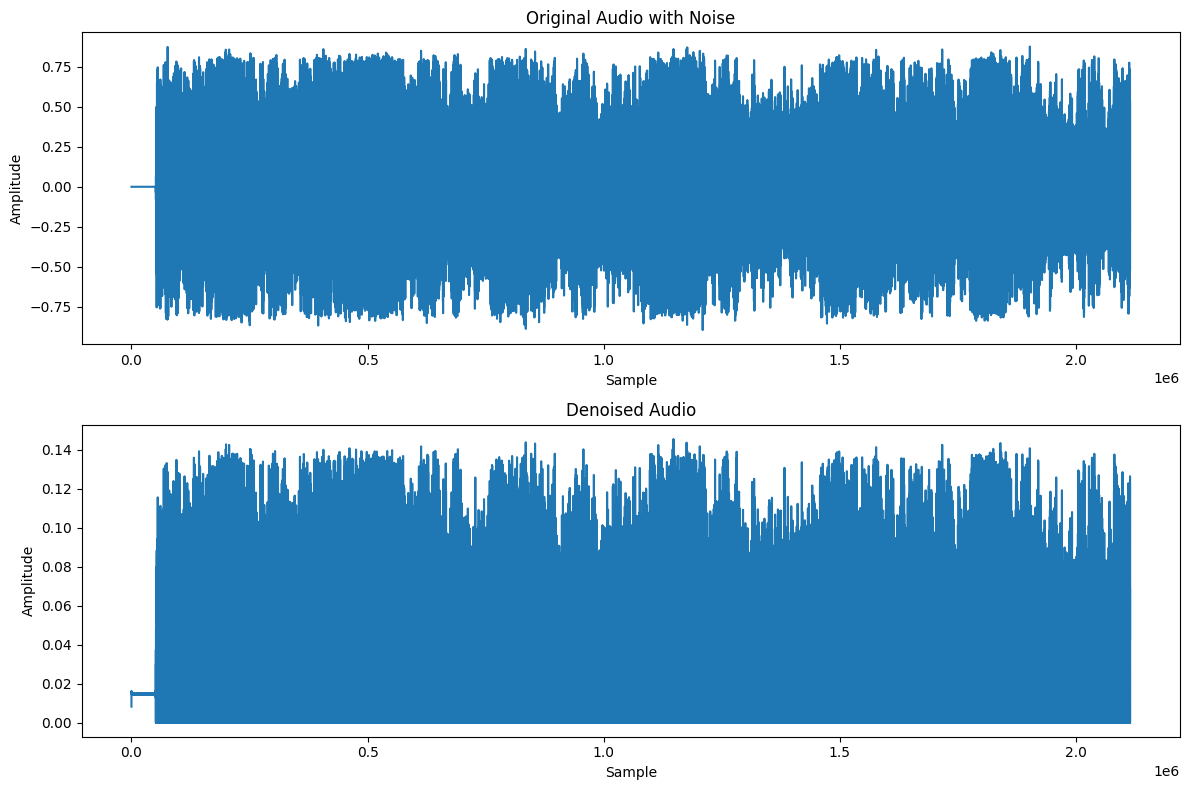

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv1D(16, kernel_size=3, padding='same', activation='relu'),
            tf.keras.layers.Conv1D(8, kernel_size=3, padding='same', activation='relu'),
            tf.keras.layers.Conv1D(4, kernel_size=3, padding='same', activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv1DTranspose(8, kernel_size=3, padding='same', activation='relu'),
            tf.keras.layers.Conv1DTranspose(16, kernel_size=3, padding='same', activation='relu'),
            tf.keras.layers.Conv1DTranspose(1, kernel_size=3, padding='same', activation='relu')
        ])

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def train_model(model, data, num_epochs=10, batch_size=32, learning_rate=0.001):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mae')
    model.fit(data, data, epochs=num_epochs, batch_size=batch_size)

def load_audio_data(file_path):
    audio, sample_rate = sf.read(file_path)
    audio = np.expand_dims(audio, axis=0)
    audio = np.expand_dims(audio, axis=2)
    return audio

if __name__ == '__main__':
    file_path = 'audio_with_noise.wav'
    audio_data = load_audio_data(file_path)

    model = Autoencoder()

    audio_data = tf.reshape(audio_data, (-1, audio_data.shape[1], 1))

    train_model(model, audio_data)

    denoised_audio = model.predict(audio_data)

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(audio_data[0])
    plt.title('Original Audio with Noise')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(denoised_audio[0])
    plt.title('Denoised Audio')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

    sf.write('denoised_audio_tensorflow.wav', denoised_audio[0, :, 0], sample_rate)
